# Blob detection for vehicle recognition

## Vehicle Recognition
In this task we chose the vehicle recognition dataset, because it can clearly visualize how blobdetection can be used to recognize different features of an image. Scimage and cv2 have some useful functions for detecting blobs, and we will be testing Laplacian of Gaussian (LoG), Difference of Gaussian (DoG) and Determinant of Hessian (DoH). 

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import cv2


motorcycle = cv2.imread('vehicles/motorcycle/PIC_100.jpg')
hatchback = cv2.imread('vehicles/hatchback/PIC_100.jpg')
pickup = cv2.imread('vehicles/pickup/PIC_100.jpg')
sedan = cv2.imread('vehicles/sedan/PIC_100.jpg')
suv = cv2.imread('vehicles/suv/PIC_100.jpg')
images = [motorcycle, hatchback, pickup, sedan, suv]

# Convert images to grayscale
gray_motorcycle = cv2.cvtColor(motorcycle, cv2.COLOR_BGR2GRAY)
gray_hatchback = cv2.cvtColor(hatchback, cv2.COLOR_BGR2GRAY)
gray_pickup = cv2.cvtColor(pickup, cv2.COLOR_BGR2GRAY)
gray_sedan = cv2.cvtColor(sedan, cv2.COLOR_BGR2GRAY)
gray_suv = cv2.cvtColor(suv, cv2.COLOR_BGR2GRAY)

# Store grayscale images in a list
gray_images = [gray_motorcycle, gray_hatchback, gray_pickup, gray_sedan, gray_suv]
titles = ['Motorcycle', 'Hatchback', 'Pickup', 'Sedan', 'SUV']

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


# Visualizing of the blob-detection algorithm


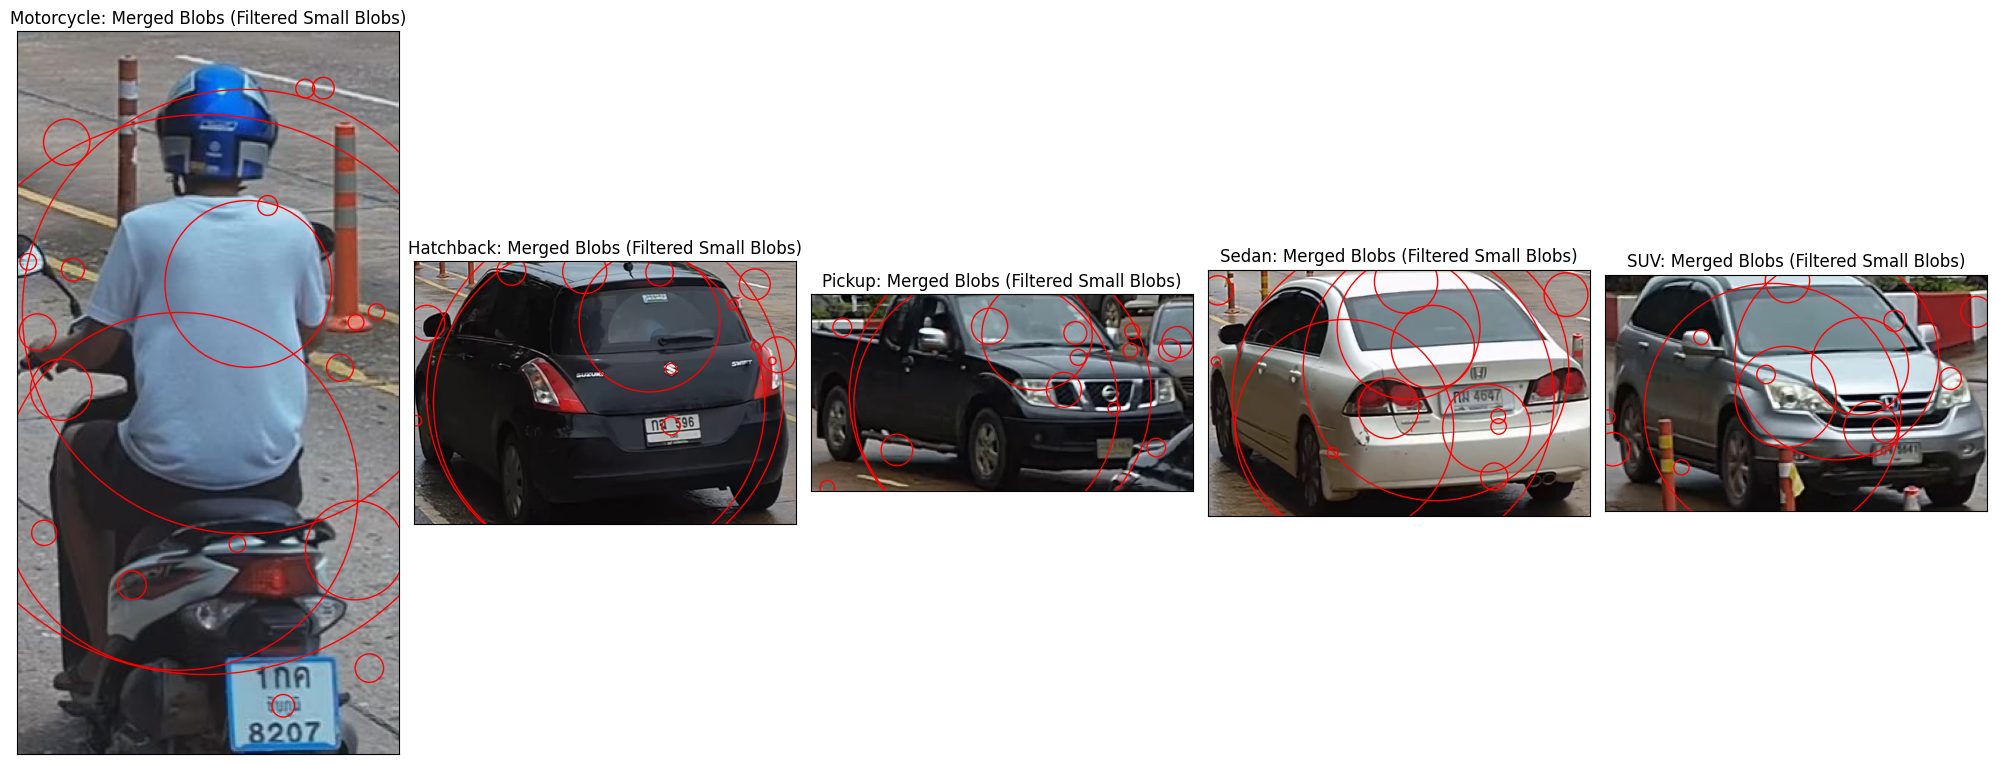

In [129]:

# Define the threshold values
min_threshold = 100
max_threshold = 200
threshold_step = 50  # Step size for thresholding within the range
min_dist_between_blobs = 10  # Minimum distance to merge blobs
min_blob_size = 5  # Minimum radius to keep a blob

# Function to compute blob centers and radii using connected components
def compute_blob_centers_and_radii(binary_image):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)
    
    # Radii are calculated based on the area of each blob (Assume circular blobs)
    radii = np.sqrt(stats[:, cv2.CC_STAT_AREA] / np.pi)
    return centroids, radii

# Function to merge blobs based on proximity
def merge_blobs(centroids, radii, min_dist_between_blobs):
    merged_centroids = []
    merged_radii = []
    
    while len(centroids) > 0:
        # Pop the first centroid and corresponding radius
        base_center = centroids[0]
        base_radius = radii[0]
        
        # Compute distances from this centroid to the others
        distances = cdist([base_center], centroids[1:])
        
        # Find the blobs that are closer than the minimum distance
        close_indices = np.where(distances < min_dist_between_blobs)[1]
        
        # Merge all close blobs by averaging their centers and radii
        merge_centers = np.vstack([base_center, centroids[1:][close_indices]])
        merge_radii = np.hstack([base_radius, radii[1:][close_indices]])
        
        avg_center = np.mean(merge_centers, axis=0)
        avg_radius = np.mean(merge_radii)
        
        # Store the merged center and radius
        merged_centroids.append(avg_center)
        merged_radii.append(avg_radius)
        
        # Remove merged blobs from the lists
        centroids = np.delete(centroids, np.hstack(([0], close_indices + 1)), axis=0)
        radii = np.delete(radii, np.hstack(([0], close_indices + 1)))
    
    return np.array(merged_centroids), np.array(merged_radii)

# Create a figure with subplots for each image
fig, axs = plt.subplots(1, len(images), figsize=(20, 16))  # One row for merged blobs

# Iterate over each color image
for i, image in enumerate(images):
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    all_centroids = []
    all_radii = []
    
    # Apply thresholds within the specified range
    for thresh in range(min_threshold, max_threshold + 1, threshold_step):
        # Apply threshold to get a binary image
        _, binary_image = cv2.threshold(grey_image, thresh, 255, cv2.THRESH_BINARY)
        
        # Detect blobs using connected components
        centroids, radii = compute_blob_centers_and_radii(binary_image)
        
        # Append the detected blobs to the lists for later merging
        all_centroids.append(centroids)
        all_radii.append(radii)
    
    # Flatten the list of centroids and radii for all thresholds
    all_centroids = np.vstack(all_centroids)
    all_radii = np.hstack(all_radii)
    
    # Merge blobs across different threshold steps
    merged_centroids, merged_radii = merge_blobs(all_centroids, all_radii, min_dist_between_blobs)
    
    # Filter out small blobs based on the minimum radius
    filtered_centroids = merged_centroids[merged_radii >= min_blob_size]
    filtered_radii = merged_radii[merged_radii >= min_blob_size]
    
    # Plot the original color image
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert to RGB for correct color representation
    axs[i].set_title(f'{titles[i]}: Merged Blobs (Filtered Small Blobs)')
    
    # Plot the merged blobs
    for center, radius in zip(filtered_centroids, filtered_radii):
        if radius > 0:  # Only draw blobs with non-zero radius
            axs[i].add_patch(plt.Circle((center[0], center[1]), radius, color='r', fill=False))

    # Remove axis labels
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()


## Important statistics

In [130]:
import os
import cv2
import numpy as np
from scipy.spatial.distance import cdist

# Define the path to the root folder
root_folder = 'vehicles'

# Define a function to compute the required statistics for each image
def compute_statistics(image):
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    all_centroids = []
    all_radii = []
    
    # Apply thresholds within the specified range
    for thresh in range(min_threshold, max_threshold + 1, threshold_step):
        _, binary_image = cv2.threshold(grey_image, thresh, 255, cv2.THRESH_BINARY)
        centroids, radii = compute_blob_centers_and_radii(binary_image)
        all_centroids.append(centroids)
        all_radii.append(radii)

    # Flatten the lists of centroids and radii
    all_centroids = np.vstack(all_centroids)
    all_radii = np.hstack(all_radii)

    # Calculate number of blobs before merging
    num_blobs = len(all_centroids)

    # Merge blobs
    merged_centroids, merged_radii = merge_blobs(all_centroids, all_radii, min_dist_between_blobs)

    # Filter out small blobs based on the minimum radius
    filtered_centroids = merged_centroids[merged_radii >= min_blob_size]
    filtered_radii = merged_radii[merged_radii >= min_blob_size]

    # Calculate number of merged blobs
    num_merged_blobs = len(filtered_centroids)

    # Calculate radius range (largest - smallest)
    radius_range = np.max(filtered_radii) - np.min(filtered_radii) if filtered_radii.size > 0 else 0

    # Calculate average distance between merged blobs
    avg_distance = np.mean(cdist(filtered_centroids, filtered_centroids)[cdist(filtered_centroids, filtered_centroids) != 0]) if filtered_centroids.shape[0] > 1 else 0

    # Calculate the area of the largest blob
    largest_blob_area = np.pi * (np.max(filtered_radii) ** 2) if filtered_radii.size > 0 else 0

    # Calculate total image area
    total_image_area = image.shape[0] * image.shape[1]

    # Calculate largest blob as percentage of the screen
    largest_blob_percentage = (largest_blob_area / total_image_area) * 100 if total_image_area > 0 else 0

    return num_blobs, num_merged_blobs, radius_range, avg_distance, largest_blob_percentage

# Initialize dictionaries to hold statistics for each vehicle type
vehicle_statistics = {}

# Traverse through each vehicle type folder
for vehicle_type in os.listdir(root_folder):
    vehicle_path = os.path.join(root_folder, vehicle_type)
    
    if os.path.isdir(vehicle_path):
        # Initialize counters and sums for averaging
        total_num_blobs = 0
        total_num_merged_blobs = 0
        total_radius_range = 0
        total_avg_distance = 0
        total_largest_blob_percentage = 0
        image_count = 0
        
        # Iterate through each image in the vehicle type folder
        for image_file in os.listdir(vehicle_path):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(vehicle_path, image_file)
                image = cv2.imread(image_path)

                # Compute statistics for the image
                num_blobs, num_merged_blobs, radius_range, avg_distance, largest_blob_percentage = compute_statistics(image)

                # Accumulate the results
                total_num_blobs += num_blobs
                total_num_merged_blobs += num_merged_blobs
                total_radius_range += radius_range
                total_avg_distance += avg_distance
                total_largest_blob_percentage += largest_blob_percentage
                image_count += 1

        # Calculate averages for the vehicle type
        if image_count > 0:
            vehicle_statistics[vehicle_type] = {
                'average_num_blobs': total_num_blobs / image_count,
                'average_num_merged_blobs': total_num_merged_blobs / image_count,
                'average_radius_range': total_radius_range / image_count,
                'average_avg_distance': total_avg_distance / image_count,
                'average_largest_blob_percentage': total_largest_blob_percentage / image_count
            }

# Display the average statistics for each vehicle type
for vehicle_type, stats in vehicle_statistics.items():
    print(f"Statistics for {vehicle_type}:")
    print(f"  Average number of blobs detected: {stats['average_num_blobs']:.2f}")
    print(f"  Average number of merged blobs: {stats['average_num_merged_blobs']:.2f}")
    print(f"  Average radius range: {stats['average_radius_range']:.2f}")
    print(f"  Average distance between merged blobs: {stats['average_avg_distance']:.2f}")
    print(f"  Average largest blob as percentage of the screen: {stats['average_largest_blob_percentage']:.2f}%\n")


Statistics for hatchback:
  Average number of blobs detected: 261.25
  Average number of merged blobs: 14.97
  Average radius range: 123.88
  Average distance between merged blobs: 136.03
  Average largest blob as percentage of the screen: 69.64%

Statistics for motorcycle:
  Average number of blobs detected: 438.30
  Average number of merged blobs: 17.14
  Average radius range: 140.82
  Average distance between merged blobs: 151.13
  Average largest blob as percentage of the screen: 77.64%

Statistics for pickup:
  Average number of blobs detected: 304.60
  Average number of merged blobs: 16.33
  Average radius range: 114.84
  Average distance between merged blobs: 127.17
  Average largest blob as percentage of the screen: 70.55%

Statistics for sedan:
  Average number of blobs detected: 278.40
  Average number of merged blobs: 15.48
  Average radius range: 121.70
  Average distance between merged blobs: 136.63
  Average largest blob as percentage of the screen: 65.91%

Statistics for

Above is a list of statistics for blob detection on each of the different vehicle types. Given the variety in the dataset, the sizes of the blobs can vary. This is because there are different camera angles and different vehicle types that all have different features. Therefore we track the largest blob as a percentage of the screen to see if it in fact is the entire vehicle that is detected by the largest blob or just the features and part of the vehicle. 
Interestingly, motorcycles consistently produce the largest blobs among all vehicle types. This phenomenon may be influenced by several factors, including the image format and the method by which the blob is generated.
We observed a substantial number of blobs detected for each vehicle prior to merging. However, this number was significantly reduced after the merging process, resulting in clearer and more accurate blob detection. Additionally, analyzing the average distance between blobs can provide insights into the type of vehicle depicted in the image, as different vehicles have varying feature distributions and spacings. Position of the centroids will therefore not be as useful as it might be to other datasets.


# Important Parameters



Blob detection can be broken into four parts:
- Thresholding 
- Grouping 
- Merging
- Center
  

## Thresholding parameters 
For thresholding, we first need to break the images down to binary, and we do this by using different thresholds. Tuning this allows us to detect small or large blobs based on local maxima by the edges. This is an important parameter because the environment often contain noise that reduces the accuracy of the algorithm. In the following image you can see a comparison of different thresholds for the image.We can see that starting with a minThreshold of 100, and a maxThreshold of 200 gives us a good blob detection. threshold_step is 50 and will therefore provide 3 images that detects blobs. This means that important blobs are not lost, and with a high max_threshold some of the features are getting clearer in the image. 200 and upwards are not visible binary-images, and are therefore not viable. 

In [131]:
# Define different threshold values
min_threshold = 100
max_threshold = 200
threshold_step = 50

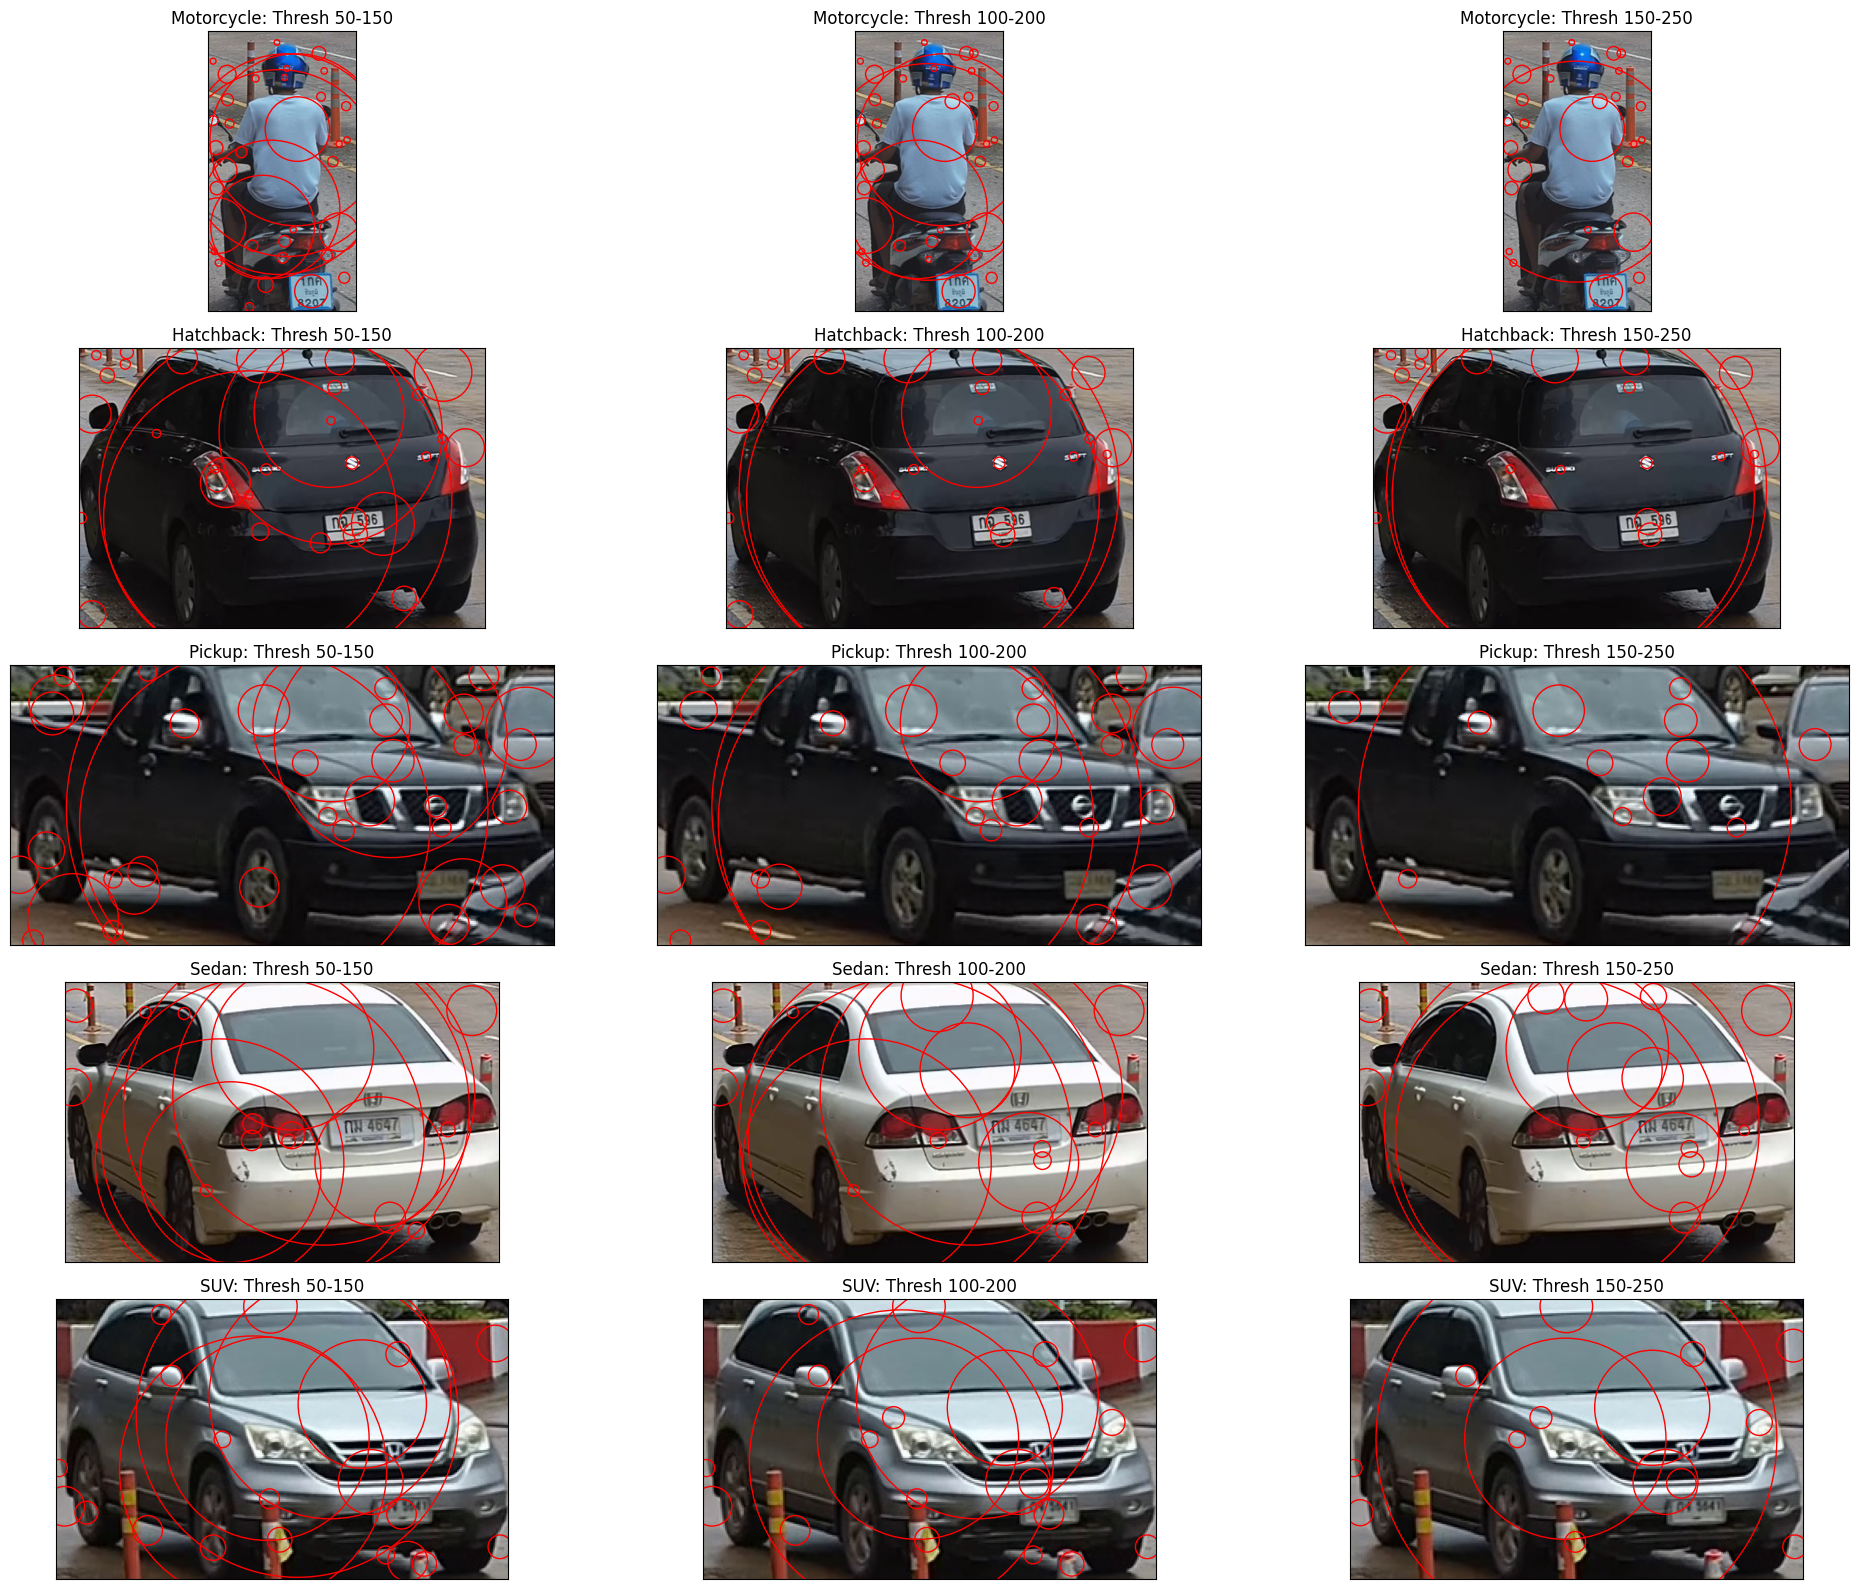

In [132]:


# Define min-max threshold pairs to experiment with
threshold_pairs = [(50, 150), (100, 200), (150, 250)]  # Example pairs

threshold_step = 50  # Step size for thresholding within each min-max range
min_dist_between_blobs = 10  # Minimum distance to merge blobs

# Function to compute blob centers and radii using connected components
def compute_blob_centers_and_radii(binary_image):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)
    
    # Radii are calculated based on the area of each blob (Assume circular blobs)
    radii = np.sqrt(stats[:, cv2.CC_STAT_AREA] / np.pi)
    return centroids, radii

# Function to merge blobs based on proximity
def merge_blobs(centroids, radii, min_dist_between_blobs):
    # Only consider blobs with radius >= 5
    valid_mask = radii >= 5
    centroids = centroids[valid_mask]
    radii = radii[valid_mask]

    merged_centroids = []
    merged_radii = []
    
    while len(centroids) > 0:
        # Pop the first centroid and corresponding radius
        base_center = centroids[0]
        base_radius = radii[0]
        
        # Compute distances from this centroid to the others
        distances = cdist([base_center], centroids[1:])
        
        # Find the blobs that are closer than the minimum distance
        close_indices = np.where(distances < min_dist_between_blobs)[1]
        
        # Merge all close blobs by averaging their centers and radii
        merge_centers = np.vstack([base_center, centroids[1:][close_indices]])
        merge_radii = np.hstack([base_radius, radii[1:][close_indices]])
        
        avg_center = np.mean(merge_centers, axis=0)
        avg_radius = np.mean(merge_radii)
        
        # Store the merged center and radius
        merged_centroids.append(avg_center)
        merged_radii.append(avg_radius)
        
        # Remove merged blobs from the lists
        centroids = np.delete(centroids, np.hstack(([0], close_indices + 1)), axis=0)
        radii = np.delete(radii, np.hstack(([0], close_indices + 1)))
    
    return np.array(merged_centroids), np.array(merged_radii)

# Create a figure with subplots for each image and threshold pair combination
fig, axs = plt.subplots(len(images), len(threshold_pairs), figsize=(20, 16))

# Iterate over each color image
for i, image in enumerate(images):
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # For each min-max threshold pair, we calculate and plot the merged blobs
    for k, (min_threshold, max_threshold) in enumerate(threshold_pairs):
        all_centroids = []
        all_radii = []
        
        # Apply thresholds within the current min-max threshold range
        for thresh in range(min_threshold, max_threshold + 1, threshold_step):
            # Apply threshold to get a binary image
            _, binary_image = cv2.threshold(grey_image, thresh, 255, cv2.THRESH_BINARY)
            
            # Detect blobs using connected components
            centroids, radii = compute_blob_centers_and_radii(binary_image)
            
            # Append the detected blobs to the lists for later merging
            all_centroids.append(centroids)
            all_radii.append(radii)
        
        # Flatten the list of centroids and radii for all thresholds
        all_centroids = np.vstack(all_centroids)
        all_radii = np.hstack(all_radii)
        
        # Merge blobs across different threshold steps
        merged_centroids, merged_radii = merge_blobs(all_centroids, all_radii, min_dist_between_blobs)
        
        # Plot the original color image
        axs[i, k].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert to RGB for correct color representation
        axs[i, k].set_title(f'{titles[i]}: Thresh {min_threshold}-{max_threshold}')
        
        # Plot the merged blobs, filtering out those with radius < 5
        for center, radius in zip(merged_centroids, merged_radii):
            if radius >= 5:  # Only draw blobs with radius >= 5
                axs[i, k].add_patch(plt.Circle((center[0], center[1]), radius, color='r', fill=False))

        # Remove axis labels
        axs[i, k].set_xticks([])
        axs[i, k].set_yticks([])

# Adjust layout and show the plot 
plt.tight_layout()
plt.show()


## Grouping-parameters and center calculation
- connectedComponentsWithStats() is an important function from OpenCV, because it takes in a binary-image and finds blobs (areas) that are white pixels. It provides the center of the area (centroid) as well as radii of the blob. It also provides other useful stats, such as the number of blobs, as well as stats - giving x,y position and size. 
- When labeling the groups, it becomes apparent why threshold_step is important, because you can clearly see the different groups being formed for each step, which in turn are added as blobs.

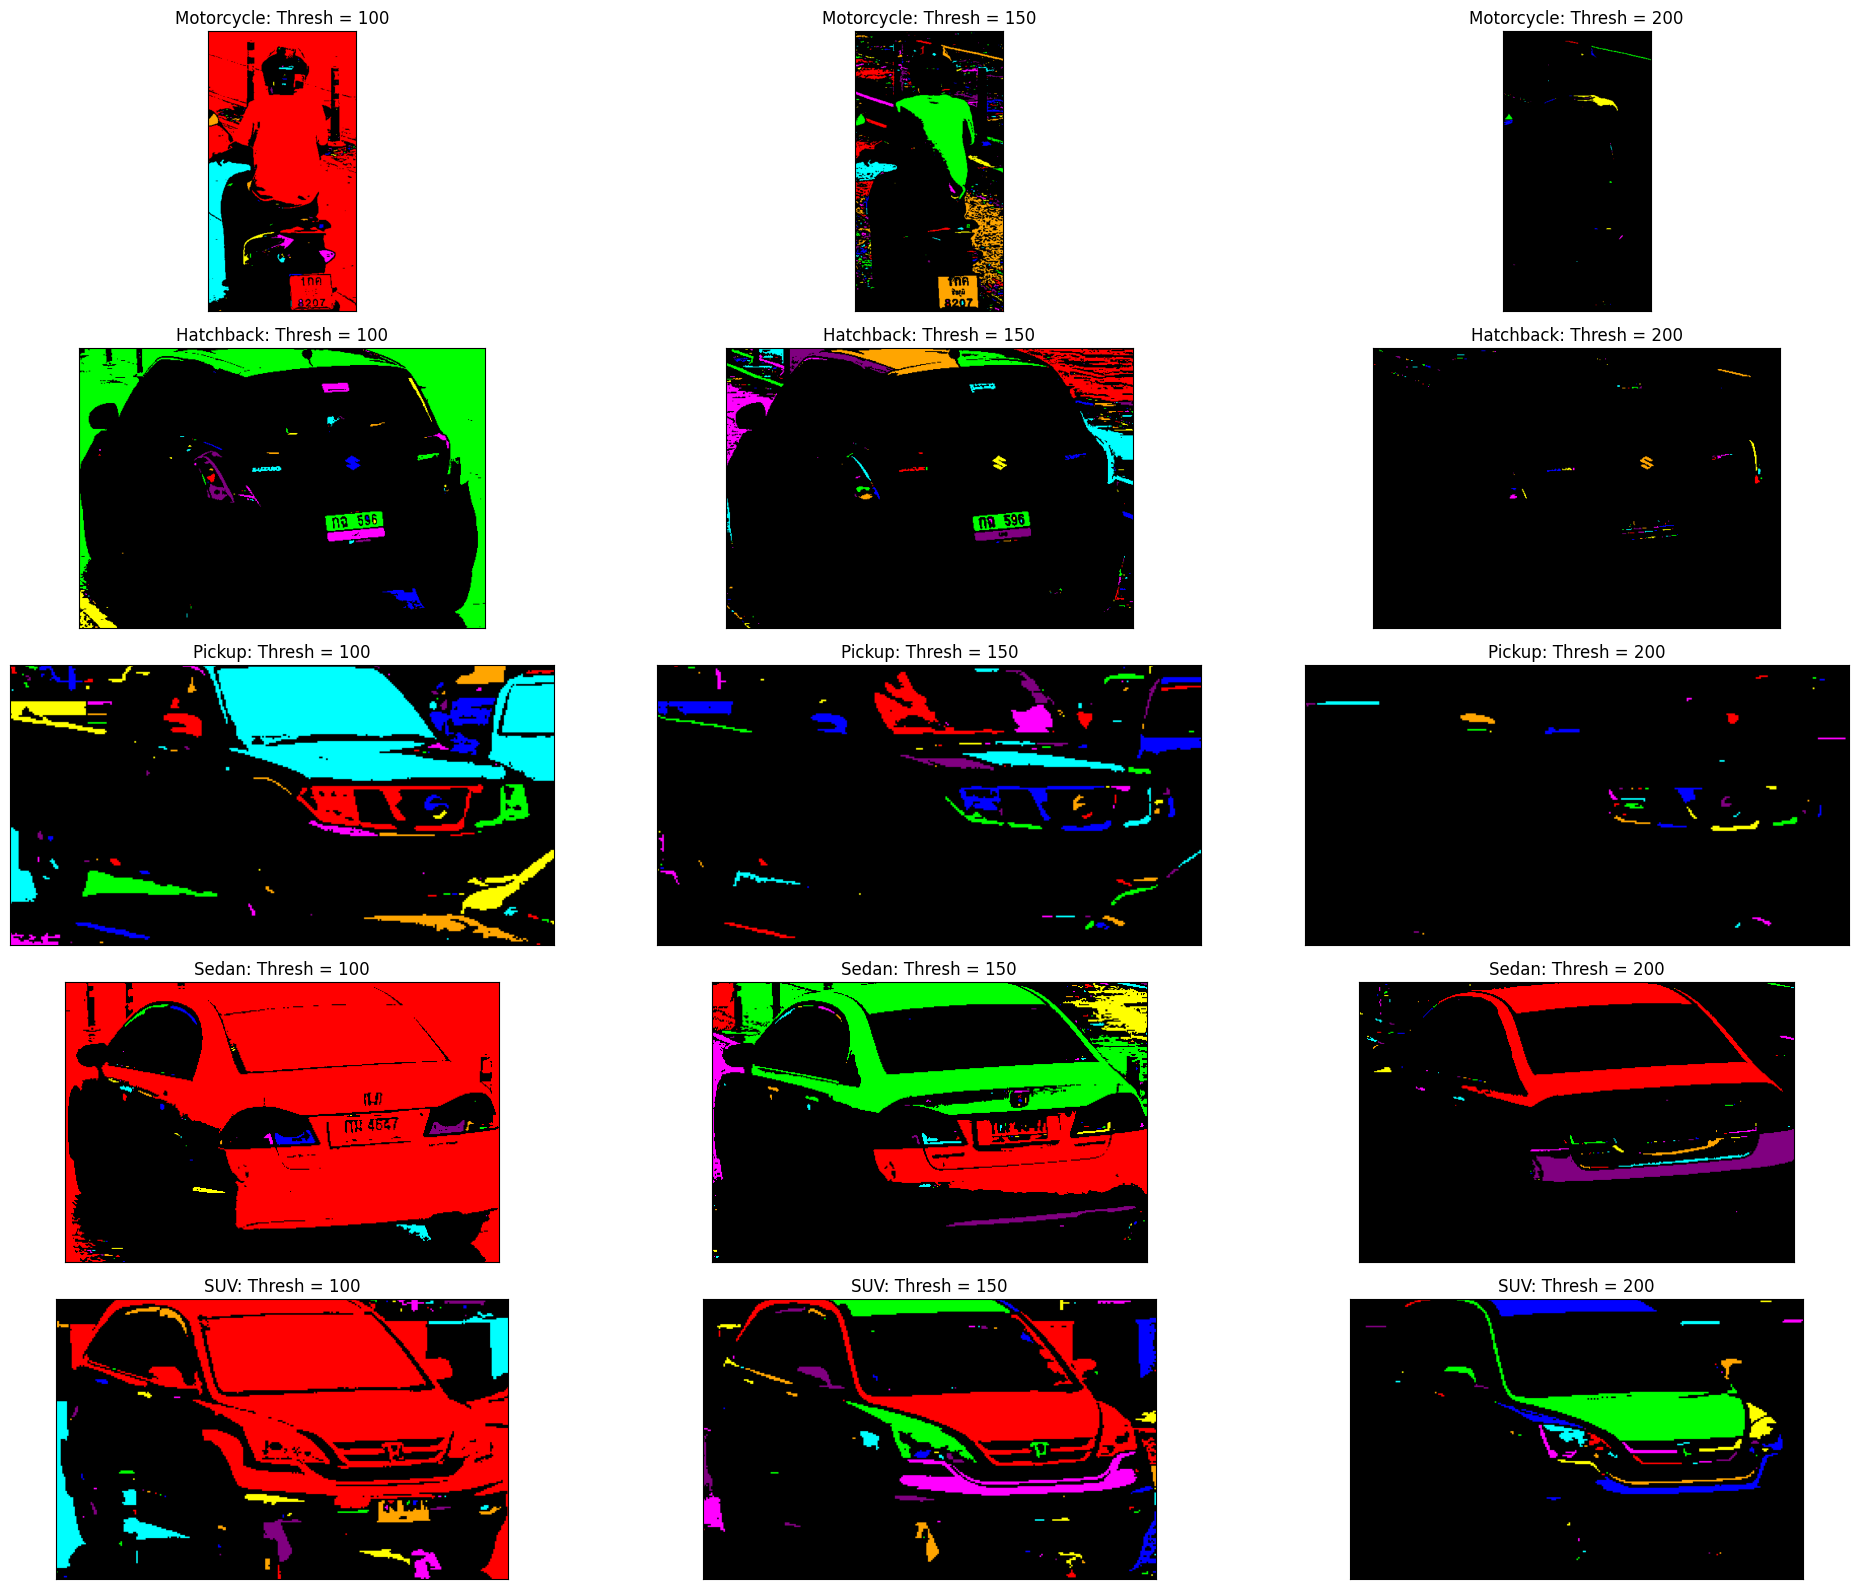

In [133]:
gray_images = [gray_motorcycle, gray_hatchback, gray_pickup, gray_sedan, gray_suv]
titles = ['Motorcycle', 'Hatchback', 'Pickup', 'Sedan', 'SUV']

# Define thresholds
min_threshold = 100
max_threshold = 200
threshold_step = 50

# Predefined color palette (using RGB values)
color_palette = [
    (255, 0, 0),   # Red
    (0, 255, 0),   # Green
    (0, 0, 255),   # Blue
    (255, 255, 0), # Yellow
    (255, 0, 255), # Magenta
    (0, 255, 255), # Cyan
    (128, 0, 128), # Purple
    (255, 165, 0), # Orange
]

# Function to visualize connected components with a fixed color palette
def visualize_connected_components_custom(binary_image):
    # Perform connected components analysis
    num_labels, labels = cv2.connectedComponents(binary_image)
    
    # Create an output image of the same size, with 3 channels for color
    colored_image = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)
    
    # Apply different colors from the palette to each label
    for label in range(1, num_labels):  # Start from 1 to skip the background
        # Cycle through the palette colors
        color = color_palette[(label - 1) % len(color_palette)]
        colored_image[labels == label] = color  # Color all pixels with the same label
    
    return colored_image

# Create a figure with subplots for each image and threshold
fig, axs = plt.subplots(len(gray_images), (max_threshold - min_threshold) // threshold_step + 1, figsize=(20, 16))

# Iterate over each grayscale image
for i, gray_image in enumerate(gray_images):
    # Apply different thresholds for each grayscale image
    for j, thresh in enumerate(range(min_threshold, max_threshold + 1, threshold_step)):
        # Apply threshold to get a binary image
        _, binary_image = cv2.threshold(gray_image, thresh, 255, cv2.THRESH_BINARY)
        
        # Visualize connected components (blobs) with the custom color palette
        colored_blobs_image = visualize_connected_components_custom(binary_image)
        
        # Plot the colored connected components
        axs[i, j].imshow(colored_blobs_image)
        axs[i, j].set_title(f'{titles[i]}: Thresh = {thresh}')
        
        # Remove axis labels
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Merging parameters
- distances, base_center and min_dist_between_blobs are important parameters to ensure merging of blobs. Base_center is the centroid of the blob being processed, and distance (from each other blob) is calculated by using cdist (a SciPy function). min_dist_between_blobs is the value that decides how close blobs need to be for blobs to merge. Changing this parameter can change the output to a large degree, as seen in the images below. We ultimately chose a value of 10 for the min-distance because the cars have big features separated by larger distances, so it makes sense that a closer merging is more representable to the original structure.

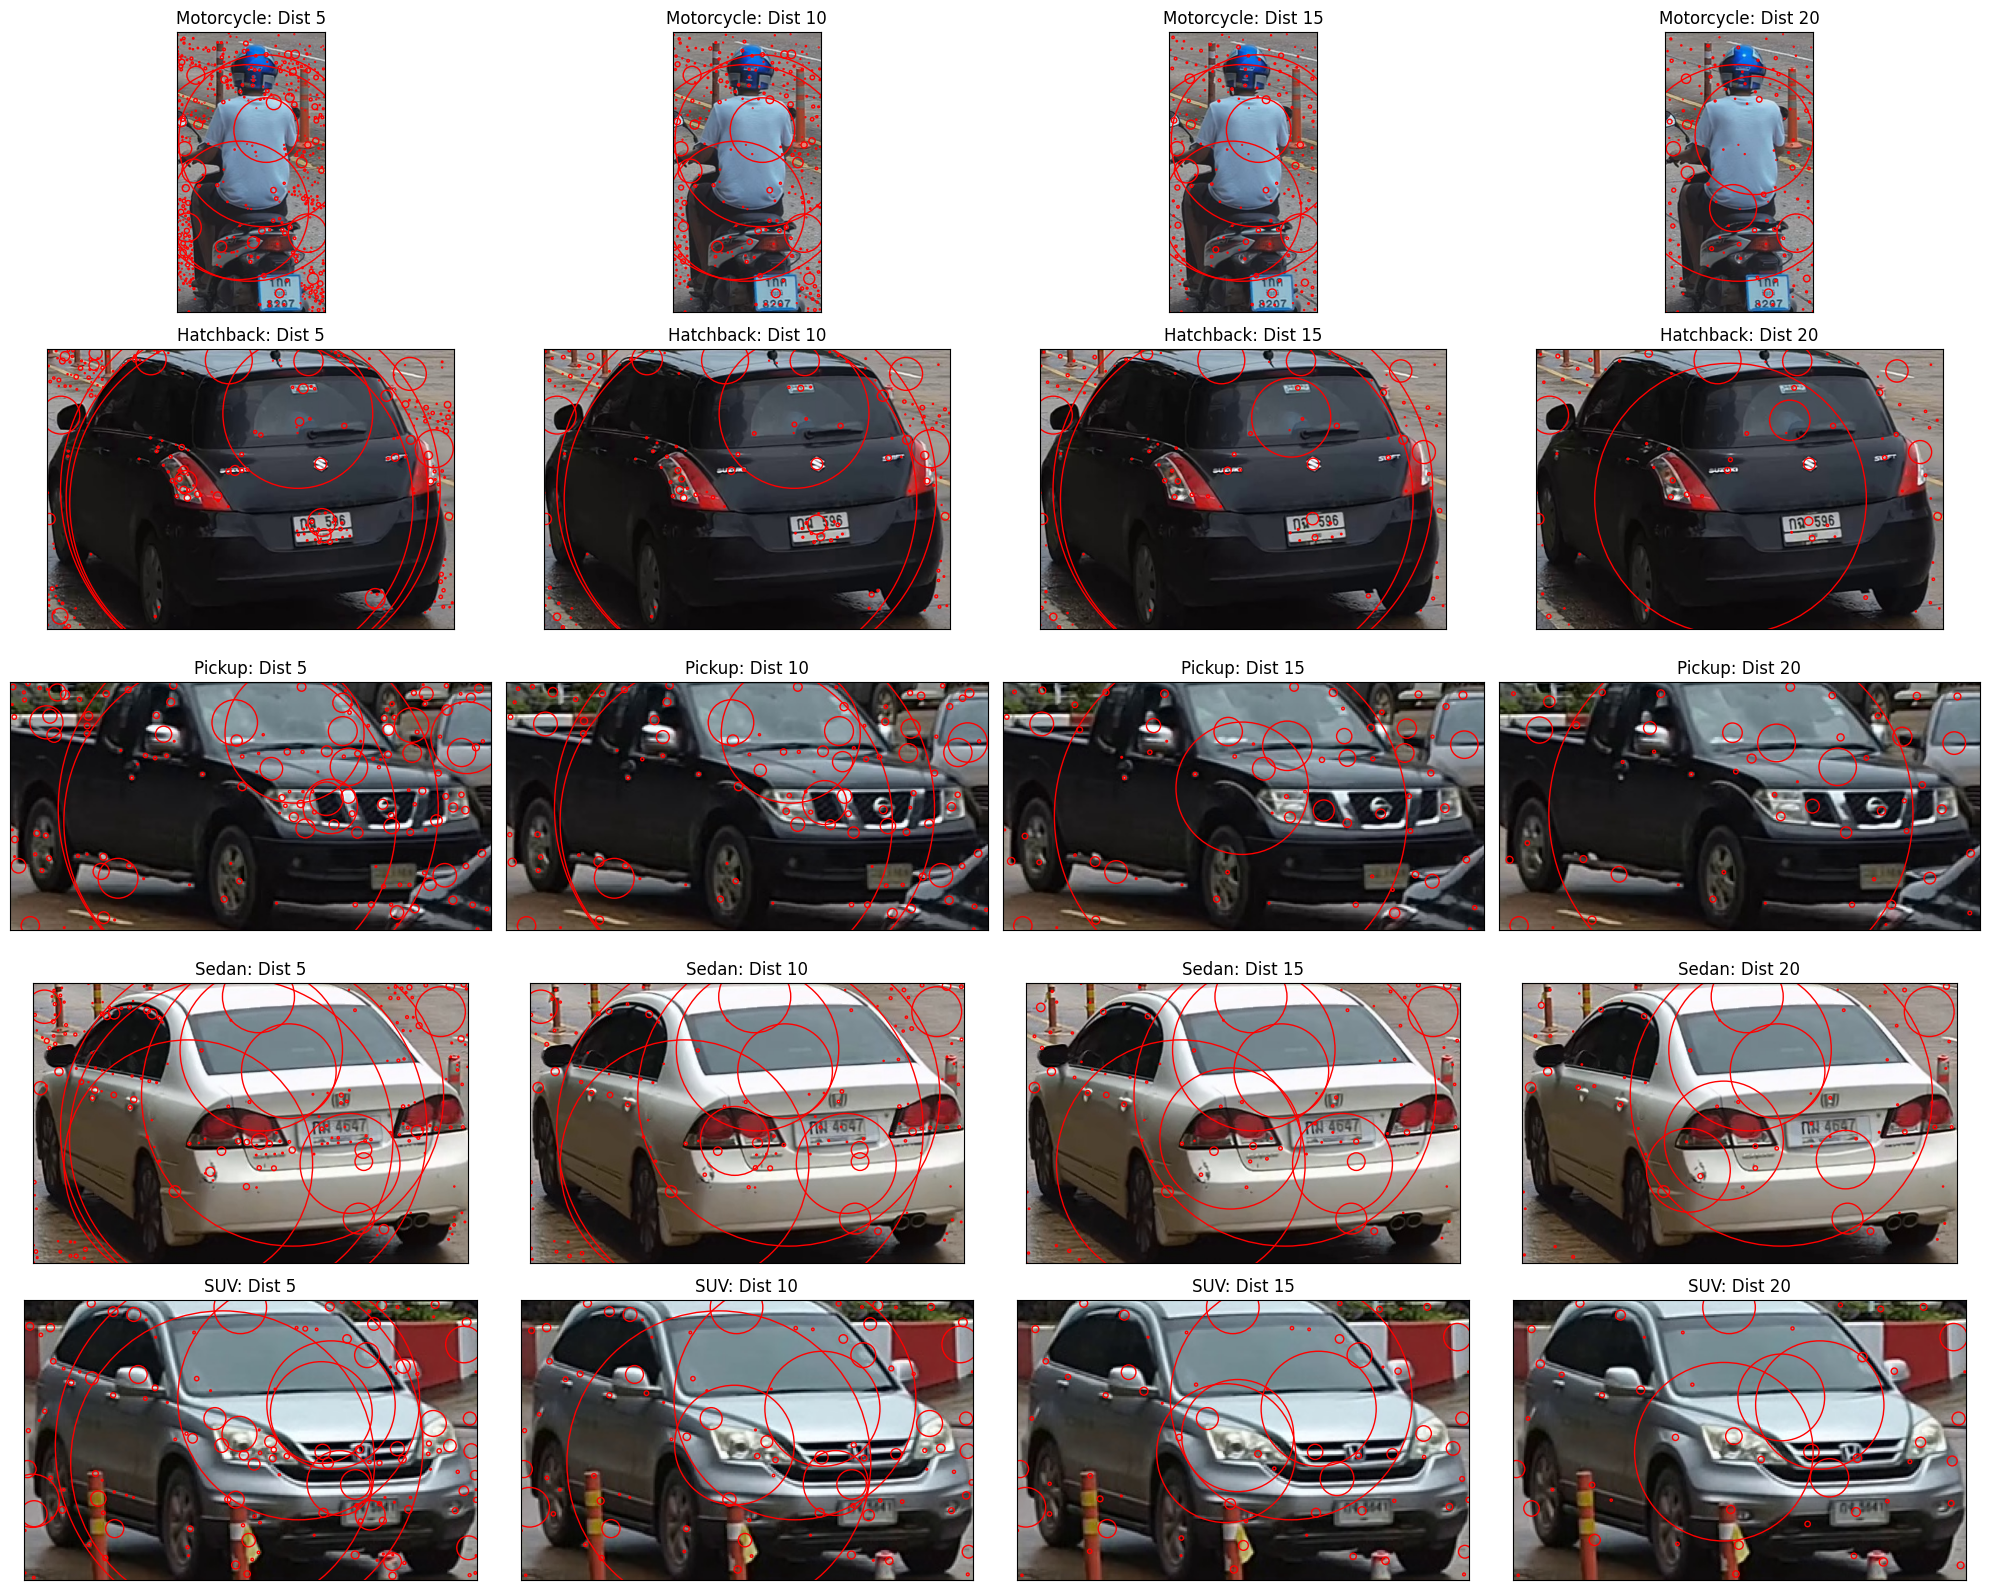

In [134]:


# Define the single min-max threshold pair and the step
min_threshold = 100
max_threshold = 200
threshold_step = 50  # Step size for thresholding within the min-max range

# Define different values for min_dist_between_blobs to experiment with
min_dist_values = [5, 10, 15, 20]  # Example values

# Function to compute blob centers and radii using connected components
def compute_blob_centers_and_radii(binary_image):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)
    
    # Radii are calculated based on the area of each blob (Assume circular blobs)
    radii = np.sqrt(stats[:, cv2.CC_STAT_AREA] / np.pi)
    return centroids, radii

# Function to merge blobs based on proximity
def merge_blobs(centroids, radii, min_dist_between_blobs):
    merged_centroids = []
    merged_radii = []
    
    while len(centroids) > 0:
        # Pop the first centroid and corresponding radius
        base_center = centroids[0]
        base_radius = radii[0]
        
        # Compute distances from this centroid to the others
        distances = cdist([base_center], centroids[1:])
        
        # Find the blobs that are closer than the minimum distance
        close_indices = np.where(distances < min_dist_between_blobs)[1]
        
        # Merge all close blobs by averaging their centers and radii
        merge_centers = np.vstack([base_center, centroids[1:][close_indices]])
        merge_radii = np.hstack([base_radius, radii[1:][close_indices]])
        
        avg_center = np.mean(merge_centers, axis=0)
        avg_radius = np.mean(merge_radii)
        
        # Store the merged center and radius
        merged_centroids.append(avg_center)
        merged_radii.append(avg_radius)
        
        # Remove merged blobs from the lists
        centroids = np.delete(centroids, np.hstack(([0], close_indices + 1)), axis=0)
        radii = np.delete(radii, np.hstack(([0], close_indices + 1)))
    
    return np.array(merged_centroids), np.array(merged_radii)

# Create a figure with subplots for each image and distance value combination
fig, axs = plt.subplots(len(images), len(min_dist_values), figsize=(20, 16))

# Iterate over each color image
for i, image in enumerate(images):
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # For each min_dist_between_blobs value, we calculate and plot the merged blobs
    for k, min_dist_between_blobs in enumerate(min_dist_values):
        all_centroids = []
        all_radii = []
        
        # Apply thresholds within the specified min-max threshold range
        for thresh in range(min_threshold, max_threshold + 1, threshold_step):
            # Apply threshold to get a binary image
            _, binary_image = cv2.threshold(grey_image, thresh, 255, cv2.THRESH_BINARY)
            
            # Detect blobs using connected components
            centroids, radii = compute_blob_centers_and_radii(binary_image)
            
            # Append the detected blobs to the lists for later merging
            all_centroids.append(centroids)
            all_radii.append(radii)
        
        # Flatten the list of centroids and radii for all thresholds
        all_centroids = np.vstack(all_centroids)
        all_radii = np.hstack(all_radii)
        
        # Merge blobs across different threshold steps
        merged_centroids, merged_radii = merge_blobs(all_centroids, all_radii, min_dist_between_blobs)
        
        # Plot the original color image
        axs[i, k].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert to RGB for correct color representation
        axs[i, k].set_title(f'{titles[i]}: Dist {min_dist_between_blobs}')
        
        # Plot the merged blobs
        for center, radius in zip(merged_centroids, merged_radii):
            if radius > 0:  # Only draw blobs with non-zero radius
                axs[i, k].add_patch(plt.Circle((center[0], center[1]), radius, color='r', fill=False))

        # Remove axis labels
        axs[i, k].set_xticks([])
        axs[i, k].set_yticks([])

plt.tight_layout()
plt.show()
